## Analyze A/B Test Results

## Table of Contents

- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)




<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [4]:
print("Number of rows = ",df.shape[0])

Number of rows =  294478


c. The number of unique users in the dataset.

In [5]:
print("Number of unique users = ", df.user_id.nunique())

Number of unique users =  290584


d. The proportion of users converted.

In [6]:
prop_converted_users=df.query('converted == 1').user_id.nunique()/df.user_id.nunique()
print('proportion of converted users = ',prop_converted_users)

proportion of converted users =  0.12104245244060237


e. The number of times the `new_page` and `treatment` don't match.

In [7]:
df1= df.query('(landing_page=="new_page" and group == "control") or(landing_page == "old_page" and group == "treatment") ').user_id.nunique()
print("The number of times the new_page and treatment don't match: ", df1)


The number of times the new_page and treatment don't match:  3893


f. Do any of the rows have missing values?

In [8]:
# Check for Null VaLues
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

##### There isn't missing values for this Dataframe

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2=df.query('(landing_page=="old_page" and group == "control") or(landing_page == "new_page" and group == "treatment") ')

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
print("unique user_ids for df2= ",df2.user_id.nunique())

unique user_ids for df2=  290584


b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.duplicated(['user_id'])].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.duplicated(['user_id'],keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2 = df2.drop_duplicates(['user_id'], keep='first')

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
prop_converted_users=df2.query('converted == 1').user_id.nunique()/df2.user_id.nunique()
print('proportion of converted users = ',prop_converted_users)

proportion of converted users =  0.11959708724499628


b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
control_prob= df2.query('group=="control"')['converted'].mean()
control_prob

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
treatment_prob=df2.query('group=="treatment"')['converted'].mean()
treatment_prob

0.11880806551510564

In [18]:
diff_prob=treatment_prob - control_prob
print(" the proportion of actual difference observed: ",diff_prob)

 the proportion of actual difference observed:  -0.00157823898536


d. What is the probability that an individual received the new page?

In [20]:
len(df2.query("landing_page == 'new_page'")) / df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**No I don't think that the new treatment page leads to more conversions, as in average the propotion of conversions for control group is higher than the conversions in treatment group   .**
- Half of the population received the old_page and half of the population received the new_page
- 12.04% that received the old_page were converted.
- 11.88% that received the new_page were converted. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.


$$ H_0: p_{new} - p_{old}<=0 $$

$$ H_1: p_{new} - p_{old}>0 $$


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [21]:
#Find the proportion of converted rate assuming p_new and p_old are equal
p_new = df2['converted'].mean()
print(" the conversion rate for  𝑝new  under the null: ", p_new)

 the conversion rate for  𝑝new  under the null:  0.119597087245


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [31]:
#Find the proportion of converted rate assuming p_new and p_old are equal
p_old = df2['converted'].mean()
print(" the conversion rate for  𝑝𝑜𝑙𝑑  under the null: ", p_old)

 the conversion rate for  𝑝𝑜𝑙𝑑  under the null:  0.119597087245


c. What is $n_{new}$, the number of individuals in the treatment group?

In [32]:
n_new=df2.query('group=="treatment"').shape[0]
print("Number of landing new_page = ", n_new)

Number of landing new_page =  145310


d. What is $n_{old}$, the number of individuals in the control group?

In [33]:
n_old=df2.query('group=="control"').shape[0]
print("Number of landing old_page = ", n_old)

Number of landing old_page =  145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [34]:
#Draw samples from a binomial distribution
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted.mean()

0.11911774826233569

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [35]:
#Draw samples from a binomial distribution
old_page_converted = np.random.binomial(1, p_old,n_old)
old_page_converted.mean()

0.11757781846717237

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [36]:
difference=p_new-p_old
print("difference between p_new and p_old is : ",difference)

difference between p_new and p_old is :  0.0


h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [37]:
p_diffs=[]
for _ in range(10000):
    new_page_converted = np.random.binomial(1, p_new, n_new)
    old_page_converted = np.random.binomial(1, p_old,n_old)
    new_converted_mean = new_page_converted.mean()
    old_converted_mean = old_page_converted.mean()
    p_diffs.append(new_converted_mean - old_converted_mean)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

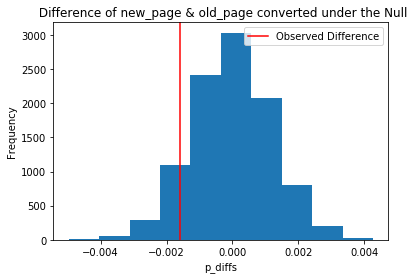

In [38]:
p_diffs=np.array(p_diffs)
plt.hist(p_diffs);
plt.axvline(x=diff_prob, color="red",label="Observed Difference");
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title(' Difference of new_page & old_page converted under the Null');
plt.legend()
plt.show()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [39]:
print(" the proportion of actual difference observed = ",diff_prob)
null_diff=p_diffs.mean()
print("the proportion of difference under the null hypothesis=  ",null_diff)

 the proportion of actual difference observed =  -0.00157823898536
the proportion of difference under the null hypothesis=   -7.93889524001e-06


In [40]:
# calculate p_value
p_val=(p_diffs > diff_prob).mean()
print("p_value = ",p_val)

p_value =  0.9057


k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

##### - Where p_value is 90% that's mean we fail to reject the null hypothesis.
##### - The null hypotheis is true.
#####  - We should keep the old page as the new page isn't statistically siginficant for conversion rate

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [41]:
import statsmodels.api as sm

convert_old = df2.query('landing_page== "old_page" and converted==1').shape[0]
print("number of old page with conversion: ",convert_old)
convert_new = df2.query('landing_page== "new_page" and converted==1').shape[0]
print("number of new page with conversion: ",convert_new)
n_old = df[df["group"]=="control"].shape[0]
print("number of all row associated with old page : ",n_old)
n_new = df[df["group"]=="treatment"].shape[0]
print("number of all row associated with new page : ",n_new)


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


number of old page with conversion:  17489
number of new page with conversion:  17264
number of all row associated with old page :  147202
number of all row associated with new page :  147276


 m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [42]:
>>> from statsmodels.stats.proportion import proportions_ztest
z_score, p_val = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],value=None, alternative='smaller', prop_var=False)
print ("z_score = {}, p_value = {}".format(z_score, p_val))

z_score = 1.3350383297192379, p_value = 0.9090680991112667


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

##### - The p_value is 91% and is higher than 0.05 significance level. That means we can not be confident with a 95% confidence level that the converted rate of the new_page is larger than the old_page.
##### -  So we fail to reject the null hypothesis as previous in part j and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

##### - type of regression should be performed to test either a conversion or no conversion is `Logistic Regression` 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [43]:
df2['intercept'] = 1
df2[['control','treatment']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [44]:
df3 = df2.rename(columns={'treatment': 'ab_page'})
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [45]:
import statsmodels.api as sm

logit = sm.Logit(df3['converted'],df3[['intercept' ,'ab_page']])
results = logit.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [46]:
results.summary2()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-10 06:46 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

##### - P_value = 18% it's greater than 5% significance level, so we fail to reject the null hypothesis and we go for the old page.
##### - This value differs from the value in Part II, because last one is two sided test and in Part II was one sided test.
##### - Here we test for not equal in our hypotheses 

$$ H_0: p_{new} = p_{old} $$
$$ H_1: p_{new} \neq p_{old} $$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

##### May be  age or gender of user might affect whether or not an individual converts or not to new page

##### Yes, I think  if we add high correlations predictor variables, leading to unreliable and unstable estimates of regression coefficients (Multicollinearity) can affect our model.Every time we include a new predictor variable with no change in sample size we lose a degree of freedom. The result often is that previously significant predictor in the new regression is no long significant at the same probability of a Type 1 error (the significance level).

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [47]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df3.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [48]:
### Create dummy variables
df_new['intercept'] = 1
df_new[['CA','US']] = pd.get_dummies(df_new['country'])[['CA','US']]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,CA,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,0


In [49]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'US']])

results = log_mod.fit()



Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [50]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-10 06:46 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9868    0.0114  -174.1736  0.0000  -2.0092  -1.9645
CA           -0.0507    0.0284    -1.7863  0.0740  -0.1064   0.0049
US           -0.0099    0.0133    -0.7458  0.4558  -0.0360   0.0161
==================================================================

"""

### Summary after using countries in our regression model

- The p_value is higher than 0.05.
- The influence of landing_page in the US is not different to the influence of landing_page in the other countries.

-  And the influence of landing_page in Canada is not different to the influence of landing_page in the other countries.
##### So , we fail to reject the null hypothesis and conclude that based on the output, there is no significant contribution from countries to differences in conversion rates for the two pages.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [53]:
#Create a new interacton between ab_page and country CA and US
df_new['CA_ab_page'] = df_new['CA'] * df_new['ab_page']
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,CA,US,CA_ab_page,US_ab_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,0,0,0


In [55]:
#Create logistic regression for the intereaction variable between ab_page and country using dummy variable
df['intercept'] = 1 # add column for interpret
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page','CA', 'US', 'CA_ab_page',  'US_ab_page']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-10 06:48 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
CA           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
US            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
CA_ab_page   -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
US_ab_page   -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
==================================================================

"""

#### We Conclude that:

None of the above variables have significant p_values (except intercept) are all above the Type I Error (5%) show NO significant effects on conversion. 
So, we failed to reject the null hypothesis and conclude that there is not sufficient evidence to suggest that there is an interaction between country and page received that will predict whether a user converts or not.

In the larger picture, based on the available information, we do not have sufficient evidence to suggest that the new page results is more conversions than the old page.



### Conclusions
- In conclusion, there is not enough evidence that the new_page increases the conversion rate as compared to the old_page. 
-  Based on the probabilities and A/B testand regression. 
- Also, There is no strong evidence that the countries (US, CA and UK) influence the conversion rate.
- The performance of the old page was found better as computed by different techniques.

##### - Since the sample size that has been tested is large so we have evidence that it isn't ecessary to continue with the new page.   

In [56]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0